In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import pickle
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Get MNIST dataset
mnist = input_data.read_data_sets('data', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
# Create the model
class VAE():
    
    def __init__(self, io_size, z_dim, hidden_size, build=True):
        # sizes
        self.io_size = io_size
        self.z_dim = z_dim
        self.hidden_size = hidden_size
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()            
            
    def placeholders(self):
        self.enc_input = tf.placeholder(tf.float32, shape=[None, self.io_size], name='enc_input')
        self.output = tf.placeholder(tf.float32, shape=[None, self.io_size], name='output')
        self.dec_mu_input = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='dec_input')
        self.dec_sigma_input = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='dec_input')
        
    def encoder(self, enc_input, reuse=False):
        with tf.variable_scope('encoder', reuse=reuse):
            # Encoder layers
            layer = tf.contrib.layers.flatten(enc_input)
            layer = tf.contrib.layers.fully_connected(layer, self.hidden_size, activation_fn=tf.nn.relu)
            mu = tf.contrib.layers.fully_connected(layer, self.z_dim, activation_fn=None)
            log_sigma = tf.contrib.layers.fully_connected(layer, self.z_dim, activation_fn=None)
            
            return mu, log_sigma
            
    def decoder(self, mu, log_sigma, reuse=False): 
        with tf.variable_scope('decoder', reuse=reuse):
            batch_size = tf.shape(mu)[0]
            z = tf.random_normal([batch_size, self.z_dim], mu, tf.exp(log_sigma))
            # Decoder layers
            layer = tf.contrib.layers.fully_connected(z, self.hidden_size, activation_fn=tf.nn.relu)        
            logits = tf.contrib.layers.fully_connected(layer, self.io_size, activation_fn=None)
            reconstituted = tf.nn.sigmoid(logits)
            
            return reconstituted, logits
            
    def build(self):
        self.placeholders()
        
        self.mu, self.log_sigma = self.encoder(self.enc_input)
        self.reconstituted, self.logits = self.decoder(self.mu, self.log_sigma)
        self.samples, _ = self.decoder(self.dec_mu_input, self.dec_sigma_input, reuse=True)
        
        # Loss functions
        self.logp = tf.reduce_sum(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.output), 
                        axis=1)
        self.kl = 0.5 * tf.reduce_sum(tf.exp(self.log_sigma) + tf.square(self.mu) - 1. - self.log_sigma, axis=1)
        self.loss = tf.reduce_mean(self.logp + self.kl)
        
        # Optimizer
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
        
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name    
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)            
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            try:
                self.__dict__[k] =  graph.get_tensor_by_name(n)
            except:
                try:
                    self.__dict__[k] =  graph.get_operation_by_name(n)
                except:
                    raise
 

In [10]:
# Train the model and save it
io_size, z_dim, hidden_size = 784, 4, 512
batch_size = 32
nepochs = 30
restore_vae = True # False, True

tf.reset_default_graph()
if restore_vae:    
    vae = VAE(io_size, z_dim, hidden_size, build=False)    
else:
    vae = VAE(io_size, z_dim, hidden_size)
    with open('chck/gc.pickle', 'wb') as f:
        pickle.dump(vae.gc, f)
   
with tf.Session() as sess:
    if restore_vae:
        saver = tf.train.import_meta_graph('chck/vae.meta')
        saver.restore(sess, "chck/vae")
        with open('chck/gc.pickle', 'rb') as f:
            gc = pickle.load(f) 
        vae.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    with tqdm(desc='Epoch', total=mnist.train.num_examples*nepochs, unit=' examples') as pbar:
        for epoch in range(nepochs):        
            for batch_idx in range(int(mnist.train.num_examples//batch_size)):
                batch = mnist.train.next_batch(batch_size)
                _, train_loss = sess.run([vae.train_step, vae.loss], 
                                        feed_dict={vae.enc_input: batch[0], vae.output: batch[0]})
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(Loss='{:.4f}'.format(train_loss))

    save_path = saver.save(sess, "chck/vae")


INFO:tensorflow:Restoring parameters from chck/vae


Epoch 30: 100%|█████████▉| 1649280/1650000 [02:13<00:00, 12376.58 examples/s, Loss=149.2547]


INFO:tensorflow:Restoring parameters from chck/vae


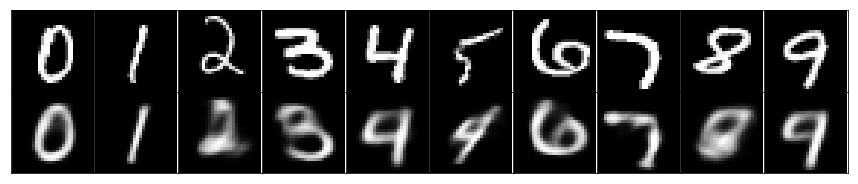

In [11]:
-



INFO:tensorflow:Restoring parameters from chck/vae


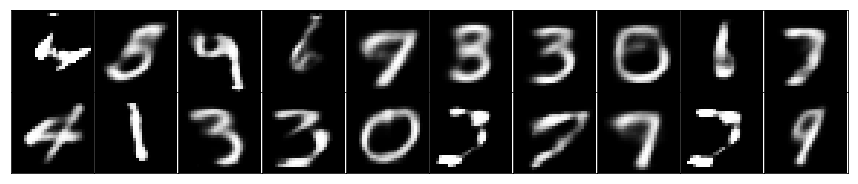

In [12]:
# Generate some samples
io_size, z_dim, hidden_size = 784, 4, 512
hsamples, vsamples = 10, 2

tf.reset_default_graph()
vae = VAE(io_size, z_dim, hidden_size, build=False)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/vae.meta')
    saver.restore(sess, "chck/vae")
    with open('chck/gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    vae.init_from_graph(sess.graph, gc) 

    mu = np.random.normal(0.0, 1.0, (hsamples*vsamples, vae.z_dim))
    log_sigma = np.random.normal(0.0, 1.0, (hsamples*vsamples, vae.z_dim))
    
    samples = sess.run(vae.samples, feed_dict={vae.dec_mu_input: mu, vae.dec_sigma_input: log_sigma})
 
fig, axes = plt.subplots(vsamples, hsamples, sharex=True, sharey=True, figsize=(1.5*hsamples,1.5*vsamples))
for ih in range(hsamples):
    for iv in range(vsamples):
        img = np.reshape(samples[ih+iv*hsamples,:], (28, 28))
        axes[iv][ih].imshow(img, aspect='equal', cmap='gray')
        axes[iv][ih].xaxis.set_visible(False)
        axes[iv][ih].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)        